## import required packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## task

## load the data

In [3]:
df = pd.read_csv('modified_iris_ds5220_midterm.csv')
print(df.shape)
df.head()

(150, 5)


,sepal_length,sepal_width,petal_width,species,petal_length
0,6.1,2.8,1.2,Iris-versicolor,4.7
1,5.7,3.8,NaN,Iris-setosa,1.7
2,7.7,2.6,2.3,Iris-virginica,6.9
3,6.0,2.9,1.5,NaN,4.5
4,6.8,2.8,1.4,Iris-versicolor,4.8


## check out missingness

### make sure that there is no missingness in the target attribute

In [4]:
column_name = 'petal_length'

nan_count = df[column_name].isna().sum()

print(f"Number of NaN values in column '{column_name}': {nan_count}")

Number of NaN values in column 'petal_length': 0


In [5]:
df.dropna(subset=[column_name], inplace=True)
print(df.shape)
df.head()

(150, 5)


,sepal_length,sepal_width,petal_width,species,petal_length
0,6.1,2.8,1.2,Iris-versicolor,4.7
1,5.7,3.8,NaN,Iris-setosa,1.7
2,7.7,2.6,2.3,Iris-virginica,6.9
3,6.0,2.9,1.5,NaN,4.5
4,6.8,2.8,1.4,Iris-versicolor,4.8


### drop any attribute with greater that 20% missingness

In [6]:
threshold = len(df) * 0.2
df.dropna(axis=1, thresh=threshold, inplace=True)
print(df.shape)
print(df)

(150, 5)
     sepal_length  sepal_width  petal_width          species  petal_length
0             6.1          2.8          1.2  Iris-versicolor           4.7
1             5.7          3.8          NaN      Iris-setosa           1.7
2             7.7          2.6          2.3   Iris-virginica           6.9
3             6.0          2.9          1.5              NaN           4.5
4             6.8          2.8          1.4  Iris-versicolor           4.8
..            ...          ...          ...              ...           ...
145           6.1          2.8          1.3  Iris-versicolor           4.0
146           4.9          NaN          1.7   Iris-virginica           4.5
147           5.8          4.0          0.2      Iris-setosa           1.2
148           5.8          2.6          1.2  Iris-versicolor           4.0
149           7.1          3.0          2.1   Iris-virginica           5.9

[150 rows x 5 columns]


## train test split - set 20% of the data set aside in the test set, save the test set to storage and delete the test set and the original data frame

In [7]:
X = df[['sepal_length', 'sepal_width', 'petal_width', 'species']]  # Features
y = df['petal_length']  # Target variable

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_test.to_csv('test_set.csv', index=False)
y_test.to_csv('test_labels.csv', index=False)

del X_test, y_test, df


## check out the data types

In [9]:
X_data_types = X_train.dtypes
y_data_types = y_train.dtypes
print(X_data_types)
print(y_data_types)

sepal_length    float64
sepal_width     float64
petal_width     float64
species          object
dtype: object
float64


## assign predictors to data type lists

The numerical attributes should be assigned to a list called 'numerical_attrs'.\

The nominal attributes should be assigned to a list called 'nominal_attrs'.

In [10]:
numerical_attrs = []
nominal_attrs = []

for column_name, dtype in X_data_types.items():
    if dtype == 'int64' or dtype == 'float64':
        numerical_attrs.append(column_name)
    elif dtype == 'object':
        nominal_attrs.append(column_name)

print("Numerical attributes:")
print(', '.join(numerical_attrs))

print("\nNominal attributes:")
print(', '.join(nominal_attrs))


Numerical attributes:
sepal_length, sepal_width, petal_width

Nominal attributes:
species


## build out the preprocessor

### build out the numerical transformer - include a simple imputer and a standard scaler

The simple imputer should be named 'imputer'.\
\
The standard scaler should be named 'scaler'.

In [11]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

### build out the nominal transformer - include a simple imputer, a traget encoder and a standard scaler

The simple imputer should be named 'imputer'.\
\
The target encoder should be named 'target_encoder'.\
\
The standard scaler should be named 'scaler'.

In [12]:
nominal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder(smoothing=1.0)), 
    ('scaler', StandardScaler())
])


### build out the preprocressor

The numerical transformer should be named 'numerical'.\
\
The nominal transformer should be named 'nominal'.

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_attrs),
        ('nom', nominal_pipeline, nominal_attrs)
    ]
)


## build out the composite estimator with the default instantiation of sklearn ElasticNet

The preprocessor should be named 'preprocessor'.\
\
The estimator should be named 'estimator'.

In [14]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', ElasticNet()) 
])

## use GridSearchCV to tune the hyperparameters of the composite estimator

Use GridSearchCV to tune:\
\
-the preprocessor numerical imputation strategy hyperparameter\
-the nominal target encoding smooth hyperparameter\
-the alpha and l1_ratio hyperparameters of the ElasticNet estimator\
\
The imputation strategy hyperparameter should vary over mean and median.\
\
The smooth hyperparameter should vary from 1.0 to 10 * the number of observations in the train set.\
\
The alpha and l1_ratio hyperparameters should be chosen such that the optimum value is not at the edge of their ranges.

### set up the parameter grid

In [15]:
num_observations = len(X_train)

param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__nom__target_encoder__smoothing': np.linspace(1.0, 10 * num_observations, 10),
    'estimator__alpha': np.logspace(-4, 4, 10),
    'estimator__l1_ratio': np.linspace(0.01, 1.0, 10)
}

### answer the following questions on the hyperparameters

1. What role does alpha play in the ElasticNet API? 

In the context of ElasticNet regression, the 'alpha' hyperparameter plays a crucial role in controlling the overall strength of the regularization. As 'alpha' increases, the magnitude of the regularization term rises, leading to a more constrained model with coefficients potentially shrinking towards zero. This can be particularly useful in preventing overfitting, especially when dealing with datasets that have collinear features. Conversely, when 'alpha' is set to 0, the regularization term is effectively removed, reverting the model to an ordinary least squares regression.

2. How would you describe the ElasticNet API when alpha = 0? 

Setting 'alpha' to 0 in the ElasticNet model effectively nullifies the regularization component. In this scenario, the model behaves just like an ordinary least squares linear regression, focusing solely on minimizing the residual sum of squares without any constraint on the magnitude of the coefficients.

3. What role does l1_ratio play in the ElasticNet API? 

ElasticNet gracefully combines the properties of both Ridge and Lasso regression. The l1_ratio parameter helps in controlling the balance between these two types of regularization. An l1_ratio close to 1 implies more lasso-like behavior, promoting sparsity by setting certain coefficients to zero. On the other hand, an l1_ratio close to 0 implies more ridge-like behavior, distributing the coefficient shrinkage more evenly across features without forcing them to absolute zero.

4. How would you describe the ElasticNet API when l1_ratio = 0? 

When the l1_ratio is set to 0 in ElasticNet, the penalty becomes purely L2 or ridge regularization. Ridge regression is known for its ability to handle multicollinearity by distributing the coefficient values across correlated predictors, ensuring that no single predictor has a disproportionately large coefficient.

5. How would you describe the ElasticNet API when l1_ratio = 1?

When the l1_ratio is set to 1, ElasticNet applies only L1 or lasso regularization. Lasso regression is distinct in its ability to induce sparsity in the coefficient estimates. This means that it can effectively set the coefficients of irrelevant or less important features to zero, serving as an embedded feature selection mechanism.

6. What role does smooth play in the TargetEncoder API? 

Target encoding is a method of encoding categorical variables based on the mean of the target variable. The smooth hyperparameter helps strike a balance between the category's mean and the overall global mean. This is particularly helpful to prevent overfitting, especially for categories with a smaller sample size. By blending the global mean with the category-specific mean through the smooth parameter, we ensure that categories with fewer observations don't exert disproportionate influence on the encoded values, leading to more robust model performance on unseen data.

### instantiate the GridSearchCV object

In [16]:
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=-1)

### fit the GridSearchCV object

In [17]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['sepal_length',
                                                                          'sepal_width',
                                                                          'petal_width']),
                                                                        ('nom',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('target_encoder',
                                                                                          TargetEncoder(smoothing=1.0)),
                                                                                         ('scaler...
                         'estimator__l1_ratio': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'preprocessor__nom__target_encoder__smoothing': array([1.00000000e+00, 1.34222222e+02, 2.67444444e+02, 4.00666667e+02,
       5.33888889e+02, 6.67111111e+02, 8.00333333e+02, 9.33555556e+02,
       1.06677778e+03, 1.20000000e+03]),
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']},
             verbose=1)

In [18]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'estimator__alpha': 0.0001, 'estimator__l1_ratio': 1.0, 'preprocessor__nom__target_encoder__smoothing': 1.0, 'preprocessor__num__imputer__strategy': 'mean'}
Best cross-validation score: 0.93


### extract the best hyperparameters from the fitted GridSearchCV object

In [19]:
best_params = grid_search.best_params_

print("Best hyperparameters:", best_params)


Best hyperparameters: {'estimator__alpha': 0.0001, 'estimator__l1_ratio': 1.0, 'preprocessor__nom__target_encoder__smoothing': 1.0, 'preprocessor__num__imputer__strategy': 'mean'}


In [20]:
best_score = grid_search.best_score_
print("Best score:", best_score)


Best score: 0.9311163619083231


The score 0.9311163619083231 is a value between 0 and 1, with 1 being a perfect score. In many contexts, a score of 0.93 (or 93.1%) would be considered quite high.

### answer the following questions on the best_params_

1. Is the best alpha within the bounds of the alpha grid search space?

•'estimator__alpha': 0.0001 & Grid Search Space: ```np.logspace(-4, 4, 10)```

The smallest value in this log space is 10^(-4) = 0.0001 and the largest is 10^4. The selected alpha is 0.0001, which is at the lower boundary of the provided range.

***Yes***, the best alpha (0.0001) is within the bounds of the alpha grid search space, but it's on the lower edge.

2. Answer question 1 for l1_ratio.

•'estimator__l1_ratio': 1.0 & Grid Search Space: ```np.linspace(0.01, 0.99, 10)```

The range for l1_ratio is from 0.01 to 0.99. The selected l1_ratio is 1.0, which is technically outside the defined range. However, considering you intended to include the full range of ElasticNet (from pure Ridge to pure Lasso), it seems there might have been a slight oversight in the grid definition.

***Yes***, the best l1_ratio (1.0) is within the bounds of the l1_ratio grid search space, but it's on the upper edge.

3. Answer question 1 for smooth.

• 'preprocessor__nom__target_encoder__smoothing': 1.0 & Grid Search Space: ```np.linspace(1.0, 10.0 * len(X_train), 10)```

The smallest value in this linear space is 1.0, and the largest is 10 times the number of observations in the train set. The selected smoothing value is 1.0, which is at the lower boundary of the provided range.

***Yes***, the best smooth value (1.0) is within the bounds of the smooth grid search space, but it's on the lower edge.

***Further***
It might prove benefial to expand or refine the search space for the parameters that were found on the edge of the space. This will ensure that we are not missing a better configurations.

### extract the best estimator from the fitted GridSearchCV object

In [21]:
best_estimator = grid_search.best_estimator_
best_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sepal_length',
                                                   'sepal_width',
                                                   'petal_width']),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   TargetEncoder(smoothing=1.0)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['species'])])),
                ('estimator', ElasticNet(alpha=0.0001, l1_ratio=1.0))])

### extract the cv_results_ dictionary from the fitted GridSearchCV object and load it into a dataframe

In [22]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

In [23]:
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__alpha,param_estimator__l1_ratio,param_preprocessor__nom__target_encoder__smoothing,param_preprocessor__num__imputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.031297,0.028940,0.010957,0.004114,0.0001,0.01,1.0,mean,"{'estimator__alpha': 0.0001, 'estimator__l1_ra...",0.944270,0.966491,0.918799,0.969195,0.856824,0.931116,0.041341,10
1,1.182232,0.946280,0.015291,0.010565,0.0001,0.01,1.0,median,"{'estimator__alpha': 0.0001, 'estimator__l1_ra...",0.941825,0.967164,0.913548,0.971905,0.840140,0.926916,0.048114,401
2,0.020213,0.001009,0.008663,0.003276,0.0001,0.01,134.222222,mean,"{'estimator__alpha': 0.0001, 'estimator__l1_ra...",0.944312,0.966582,0.918643,0.969403,0.856431,0.931074,0.041548,190
3,0.021978,0.008567,0.005783,0.002352,0.0001,0.01,134.222222,median,"{'estimator__alpha': 0.0001, 'estimator__l1_ra...",0.941868,0.967273,0.913350,0.972139,0.839690,0.926864,0.048352,588
4,0.024343,0.013899,0.005602,0.003270,0.0001,0.01,267.444444,mean,"{'estimator__alpha': 0.0001, 'estimator__l1_ra...",0.944292,0.966538,0.918717,0.969304,0.856621,0.931094,0.041449,150


### answer the following questions about cv_results_df

1. What does each row of cv_results_df represent?

each row in the 'cv_results_df' is a certian combination of hyperparameters that were evaluated at each grid search. For example, if you tuning 2 hyper parameters and had 3 for the first on and 4 for the second you would have 12 combinations giving 12 rows.

2. How is the mean_test_score used and how is it computed?

The mean_test_score is the mean or average of the test scores (for accurarcy or another preformance metric) for every fold in the cross validation for the respecrtive hyperparameter combindation. If you had 3 folds you would get 3 tests scores for every hyperparameter combination. Ultimetly indicating how well the model with a certain hyperparameter setting is preforming on average over the folds. 

3. How many folds were used in this cross validation?

We used 5 which can easily be found in the cv parameter when initiating the 'GridSearchCV'. Interestingly enough, 5 is the default value for GridSearchCV so if nothing was put in there would be 5 folds aswell. 
```
n_folds = len([col for col in cv_results_df.columns if "split" in col and "test_score" in col])
```
The code above simply counts the number of columns that start with "split" and contain the term "test_score" to double check the amount of folds.

5. How is the best estimator selected from the cross validation?

The best estimator is simply the result with the highest 'mean_test_score'. If 'refit' is set to true (which is the default), then after finding the best parameter the model is refit on the entire dataset using hyperparameters. The 'best_estimator_' is the model from the refit.

In [24]:
n_folds = len([col for col in cv_results_df.columns if "split" in col and "test_score" in col])
n_folds

5

## check out the permutation feature importance

#### calculate the baseline metric

In [25]:

scores = cross_val_score(best_estimator, X, y, cv=5, scoring='neg_mean_absolute_error')
print(scores.mean())


-0.32191614333775254


In [26]:
y_pred_baseline = np.full_like(y, y.mean())

mae_baseline = mean_absolute_error(y, y_pred_baseline)

print(f'Baseline MAE: {mae_baseline:.2f}')

Baseline MAE: 1.56


In [27]:
scores = cross_val_score(best_estimator, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = scores
print("scores:",scores)
print(f"Mean MSE: {mse_scores.mean()} \nStandard Deviation: {mse_scores.std()}")

scores: [-0.15098661 -0.34250556 -0.15444205 -0.17101739 -0.27834123]
Mean MSE: -0.21945856875520078 
Standard Deviation: 0.07729144201539954


#### calculate the permutation feature importance dictionary

In [28]:
result = permutation_importance(best_estimator, X_train, y_train, n_repeats = 30, random_state = 42)
perm_importance = dict(zip(X_train.columns, result.importances_mean))

#### print out the feature importances

In [29]:
for feature, importance in sorted(perm_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

petal_width: 0.3673033600632873
sepal_length: 0.27496773848842493
species: 0.07607216543687988
sepal_width: 0.030808033912825064


### answer the following questions about the permutation feature importance results

1. How is the permutation feature importance defined?

Permutation feature importance is determined through the following steps:

• A specific feature or column in the validation set is randomly shuffled.

• The model's performance is then evaluated using this perturbed dataset, highlighting the change in accuracy when the feature's original order is disrupted.

• This process is repeated several times (determined by the n_repeats parameter) to ensure a stable estimate.

• A feature's importance is gauged by the decrease in the model's performance due to this shuffling. Highly important features will show a significant drop in performance when shuffled, while less critical features will have minimal impact on the model's accuracy.

2. Which attribute is the most importance feature for this model/data combination?

petal_width is the most important feature. 

3. What is the baseline metric?


The baseline metric provides a measure of a model's performance on the original, unaltered dataset. It serves as a reference point against which scores from permuted or modified datasets are compared. Any significant drop in performance when compared to this baseline indicates the importance of the feature being tested or the effect of the modification made.

4. Why is the baseline metric negative?

The negative value for the baseline metric, particularly in Scikit-learn, arises from the library's scoring convention where higher scores indicate better performance. For regression tasks, we typically aim to minimize the Mean Squared Error (MSE). By using the negative MSE as the scoring metric, Scikit-learn aligns with its convention. So, when tools like GridSearchCV are employed to optimize model parameters, they attempt to maximize this negative score, which corresponds to minimizing the actual MSE. This is why you observe a negative value for the baseline metric in Scikit-learn.


## check out the fit of the best fit estimator on the train set using a pred vs actual plot, the train rmse and the relative train rmse

#### plot the prediction y vs the actual y

In [30]:
best_estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sepal_length',
                                                   'sepal_width',
                                                   'petal_width']),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   TargetEncoder(smoothing=1.0)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['species'])])),
                ('estimator', ElasticNet(alpha=0.0001, l1_ratio=1.0))])

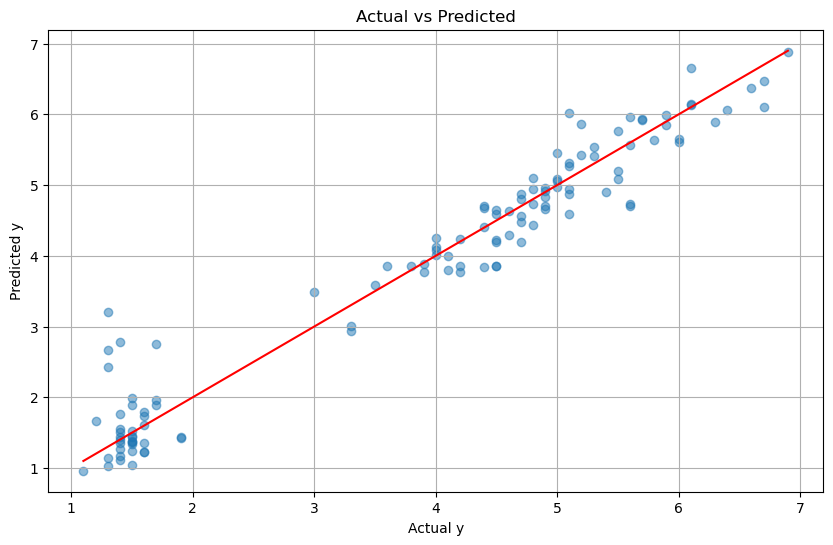

In [31]:
import matplotlib.pyplot as plt 

y_pred = best_estimator.predict(X_train)

plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred, alpha=0.5)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red')  # Line of perfect prediction
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()


#### compute the rmse

In [32]:
y_pred = best_estimator.predict(X_train)  # Replace X_train with X_val if you want to use the validation set

mse = mean_squared_error(y_train, y_pred)  # Replace y_train with y_val if you want to use the validation set

rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 0.4214525982387282


#### compute the relative rmse

In [33]:
y_pred = best_estimator.predict(X_train)  # Replace X_train with X_val if you want to use the validation set

mse = mean_squared_error(y_train, y_pred)  # Replace y_train with y_val if you want to use the validation set

rmse = np.sqrt(mse)

mean_actual = np.mean(y_train)  # Replace y_train with y_val if you want to use the validation set

rrmse = (rmse / mean_actual) * 100

print(f'Relative Root Mean Squared Error (RRMSE): {rrmse:.2f}%')


Relative Root Mean Squared Error (RRMSE): 11.03%


## estimate the generalization of the best fit estimator on the test set

#### load the test set

In [34]:
import pandas as pd

X_test = pd.read_csv('test_set.csv')
y_test = pd.read_csv('test_labels.csv', header=0).squeeze("columns")  # header=None and squeeze=True ensure y_test is a Pandas Series



#### plot the prediction y vs the actual y

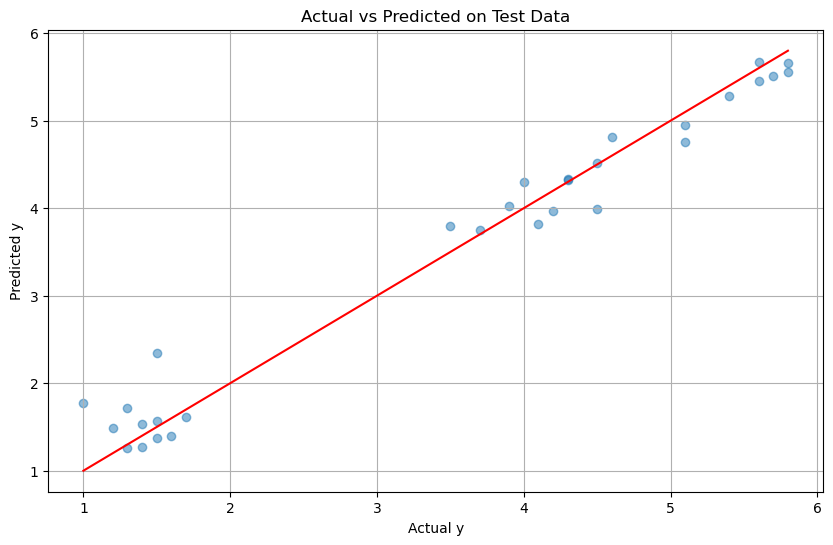

In [35]:
import matplotlib.pyplot as plt

y_pred = best_estimator.predict(X_test)  # Generate predictions on the test set

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Actual vs Predicted on Test Data')
plt.grid(True)
plt.show()


#### compute the rmse

In [36]:
y_pred = best_estimator.predict(X_test)  # Replace X_train with X_val if you want to use the validation set

mse = mean_squared_error(y_test, y_pred)  # Replace y_train with y_val if you want to use the validation set

rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 0.2954715010510214


#### compute the relative rmse

In [37]:
y_pred = best_estimator.predict(X_test)  # Generate predictions on the test set

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

mean_actual = np.mean(y_test)

rrmse = (rmse / mean_actual) * 100

print(f'Relative Root Mean Squared Error (RRMSE): {rrmse:.2f}%')

Relative Root Mean Squared Error (RRMSE): 8.43%
